<a href="https://colab.research.google.com/github/blawok/Toxic_Comments_Classification/blob/master/toxic_cnn_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

In [3]:
%matplotlib inline
import logging
import time
from platform import python_version
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [0]:
df = pd.read_csv('/content/drive/My Drive/Toxic_Comments/data/train.csv')

In [0]:
np.random.seed(42)
df = df.sample(frac=1)
df = df.reset_index(drop=True)

In [0]:
target_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [0]:
df_train = df[:1000].reset_index(drop=True)
df_val = df[10000:11000].reset_index(drop=True)
df_test = df[11000:13000].reset_index(drop=True)

In [0]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [0]:
max_seq = 100
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.comment_text.values
    ]
def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])
def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)
def targets_to_tensor(df, target_columns):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [0]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)

In [0]:
with torch.no_grad():
    x_train = bert_model(train_indices)[0]  
    x_val = bert_model(val_indices)[0]
    x_test = bert_model(test_indices)[0]
    
y_train = targets_to_tensor(df_train, target_columns)
y_val = targets_to_tensor(df_val, target_columns)
y_test = targets_to_tensor(df_test, target_columns)

In [23]:
x_train[0].shape

torch.Size([100, 768])

In [13]:
y_train[0]

tensor([0., 0., 0., 0., 0., 0.])

In [0]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__() 
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        if self.static:
            x = Variable(x)
        x = x.unsqueeze(1)  # (N, Ci, W, D) 
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)   
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)   
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [0]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [0]:
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [0]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [28]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0 
    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    # deactivate autograd engine to reduce memory usage and speed up computations
    with torch.no_grad(): 
            val_loss, batch = 0, 1
            for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
                y_pred = model(x_batch)
                loss = loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            val_losses.append(val_loss) 
            print("Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs." % (epoch + 1, train_losses[-1], val_losses[-1], elapsed))

Epoch 1 Train loss: 0.39. Validation loss: 0.15. Elapsed time: 5.82s.
Epoch 2 Train loss: 0.24. Validation loss: 0.12. Elapsed time: 5.11s.
Epoch 3 Train loss: 0.18. Validation loss: 0.10. Elapsed time: 5.08s.
Epoch 4 Train loss: 0.16. Validation loss: 0.11. Elapsed time: 5.11s.
Epoch 5 Train loss: 0.15. Validation loss: 0.10. Elapsed time: 5.09s.
Epoch 6 Train loss: 0.14. Validation loss: 0.10. Elapsed time: 5.11s.
Epoch 7 Train loss: 0.14. Validation loss: 0.10. Elapsed time: 5.12s.
Epoch 8 Train loss: 0.13. Validation loss: 0.10. Elapsed time: 5.13s.
Epoch 9 Train loss: 0.12. Validation loss: 0.10. Elapsed time: 5.16s.
Epoch 10 Train loss: 0.12. Validation loss: 0.10. Elapsed time: 5.12s.


Text(0.5, 1.0, 'Losses')

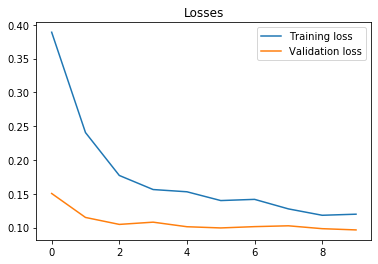

In [29]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [0]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [0]:
y_test_np = df_test[target_columns].values

In [32]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

,label,auc
1,severe_toxic,0.940791
3,threat,0.936742
5,identity_hate,0.936035
4,insult,0.902677
0,toxic,0.885197
2,obscene,0.878468
